In [1]:
import cohere
from dotenv import load_dotenv
import os
import json
from tqdm import tqdm
import pandas as pd
import time
load_dotenv()

True

## COHERE CLASSIF

In [9]:
dfs = []
for file in os.listdir('data/news_classif_dataset'):
    df = pd.read_csv('data/news_classif_dataset/' + file)
    dfs.append(df)

data = pd.concat(dfs)

df = pd.read_csv('data/bbc-news-data.csv',sep='\t')


In [10]:
content_list = data['news_article'].tolist()
content_list += df['content'].tolist()
sentences = []
for content in content_list:
    for sentence in content.split('.'):
        if len(sentence) > 0:
            sentences.append(sentence.strip())
print('Total sentences:', len(sentences))

Total sentences: 89780


In [23]:
the_sentences = []
other_sentences = []
for sentence in sentences:
    if sentence[:4] == 'The ':
        the_sentences.append(sentence)
    else:
        other_sentences.append(sentence)
print('Total sentences starting with "The":', len(the_sentences))
print('Total sentences not starting with "The":', len(other_sentences))

Total sentences starting with "The": 11534
Total sentences not starting with "The": 78246


<Axes: ylabel='Frequency'>

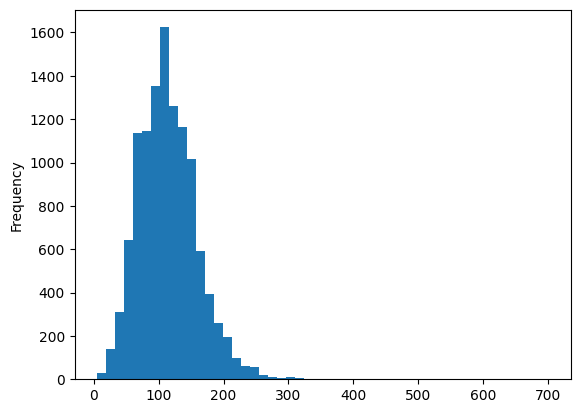

In [12]:
# Display plot of sentence length
sentence_lengths_serie = pd.Series([len(sentence) for sentence in the_sentences])
sentence_lengths_serie.plot.hist(bins=50)

<Axes: ylabel='Frequency'>

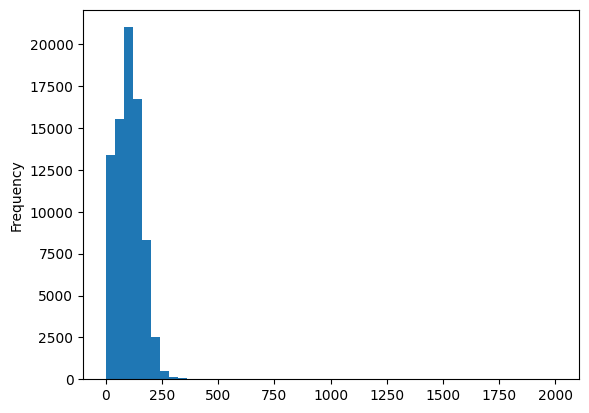

In [13]:
# Display plot of sentence length
other_sentences_lengths_serie = pd.Series([len(sentence) for sentence in other_sentences])
other_sentences_lengths_serie.plot.hist(bins=50)

In [14]:
path_test_data = "data/test_shuffle.txt"
with open(path_test_data, "r") as f:
    test_sentences = f.readlines()

Maximal length of sentence in test data:  145
Minimal length of sentence in test data:  44


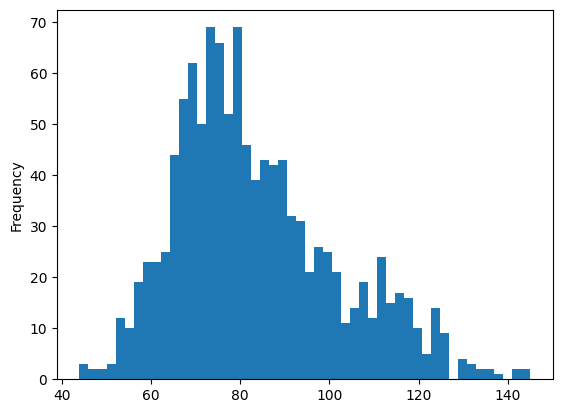

In [15]:
test_sentence_lengths_serie = pd.Series([len(sentence) for sentence in test_sentences])
test_sentence_lengths_serie.plot.hist(bins=50)
print("Maximal length of sentence in test data: ", test_sentence_lengths_serie.max())
print("Minimal length of sentence in test data: ", test_sentence_lengths_serie.min())

In [16]:
# Keep only sentences with 50 < length < 150
the_sentences = [sentence for sentence in the_sentences if len(sentence) > 50 and len(sentence) < 150]
other_sentences = [sentence for sentence in other_sentences if len(sentence) > 50 and len(sentence) < 150]

We have  8682  sentences left


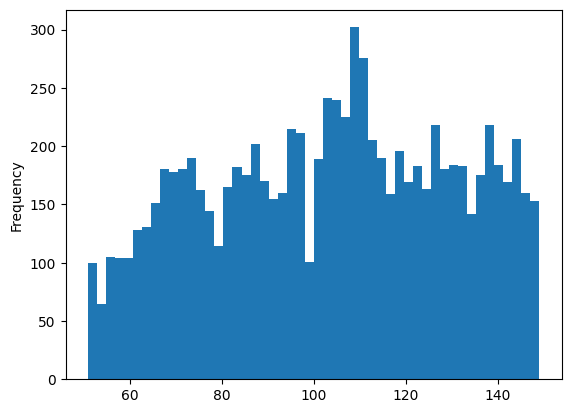

In [17]:
sentence_lengths_serie = pd.Series([len(sentence) for sentence in the_sentences])
sentence_lengths_serie.plot.hist(bins=50)
print("We have ", len(the_sentences), " sentences left")

We have  46499  sentences left


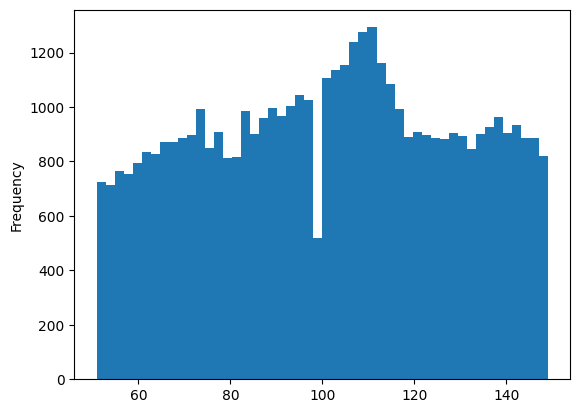

In [18]:
sentence_lengths_serie = pd.Series([len(sentence) for sentence in other_sentences])
sentence_lengths_serie.plot.hist(bins=50)
print("We have ", len(other_sentences), " sentences left")

In [19]:
for i in range(10):
    print(the_sentences[i])


The crash followed a tweet by the world's richest man Elon Musk that read 'Use Signal'
The union criticised YouTube for only taking down one video from Donald Trump rather than banning his account like Facebook and Instagram did
The device comes with a UV disinfection lamping system and collapsible arms to reach difficult-to-access areas, the airline said
The institute said its fleet can be deployed in a particular location through intelligent programming
The report said Apple recently hired Jonathan Sive, a vehicle engineer from Tesla and Waymo, as a senior manager on the car project
The company is currently working on a concrete time plan, it reported
The judge hearing the US justice department's antitrust case against Google said he will sell mutual funds he owns that hold stock of Alphabet
The "m" in the new logo is a nod to the shape of an electrical plug, the company said
The US NHTSA has determined the reports of sudden unintended acceleration (SUA) involving four different Tesl

In [32]:
path_examples = "data/train.json"
with open(path_examples, "r") as f:
  examples_raw = json.load(f)


cohere_examples = []
for label, texts in examples_raw.items():
    for text in texts:
        cohere_examples.append(cohere.ClassifyExample(text=text, label=label))

In [33]:

def parse_response(response):
    """
    Response looks like:
id='e1ba0613-6314-489d-81f5-79e34a0ba446' 
classifications=[
    ClassifyResponseClassificationsItem(
        id='1c5c5c48-6d2c-4faa-959e-41793fd44bad', 
        input='The role of credit scores in lending decisions is significant.\n', 
        prediction='Finance', 
        predictions=['Finance'], 
        confidence=0.4602186, 
        confidences=[0.4602186], 
        labels={
            'Education': ClassifyResponseClassificationsItemLabelsValue(confidence=0.0662585), 
            'Entertainment': ClassifyResponseClassificationsItemLabelsValue(confidence=0.0324937), 
            'Environment': ClassifyResponseClassificationsItemLabelsValue(confidence=0.044312477), 
            'Fashion': ClassifyResponseClassificationsItemLabelsValue(confidence=0.00911254), 
            'Finance': ClassifyResponseClassificationsItemLabelsValue(confidence=0.4602186), 
            'Food': ClassifyResponseClassificationsItemLabelsValue(confidence=0.012097831), 
            'Health': ClassifyResponseClassificationsItemLabelsValue(confidence=0.03673331), 
            'Politics': ClassifyResponseClassificationsItemLabelsValue(confidence=0.032481745), 
            'Science': ClassifyResponseClassificationsItemLabelsValue(confidence=0.022289895), 
            'Sports': ClassifyResponseClassificationsItemLabelsValue(confidence=0.03476186), 
            'Technology': ClassifyResponseClassificationsItemLabelsValue(confidence=0.22282991), 
            'Travel': ClassifyResponseClassificationsItemLabelsValue(confidence=0.026409639)
        }, 
        classification_type='single-label')
    
    __OUTPUT__:
        Records with fields: 
            "input": str, 
            "prediction":str, 
            "confidence_prediction":float, 
            "labels":list(str), 
            "confidence_labels":list(float)
    """
    data = []
    for classification in response.classifications:
        data.append({
            "text": classification.input,
            "category": classification.prediction,
            "confidence_prediction": classification.confidence,
            "labels": list(classification.labels.keys()),
            "confidence_labels": [value.confidence for value in classification.labels.values()]
        })
    
    return data



In [35]:


def cohere_classification(batch_size, rate_limit, checkpointing_folder_path, output_file_path, inputs, cohere_examples):

    ## Check if the folder exists
    if not os.path.exists(checkpointing_folder_path):
        os.makedirs(checkpointing_folder_path)
        last_batch = 0
    else:
        ## Find the last batch
        files = os.listdir(checkpointing_folder_path)
        last_batch = max([int(file.split("_")[-1].split(".")[0]) for file in files])
        print(f"Resuming from batch {last_batch}")

    
    ## Initialize the client
    co = cohere.Client(os.getenv("COHERE_API_KEY"))

    ## Split the inputs into batches
    batches_list = [inputs[i:i + batch_size] for i in range(0, len(inputs), batch_size)]

    ## Initialize the variables
    current_nb_api_calls = 0
    start_time = time.time()
    file_names = []
    i = last_batch

    for batch in tqdm(batches_list[last_batch:]):
        i += 1
        ## API call
        response = co.classify(
            inputs=batch,
            examples=cohere_examples,
        )
        current_nb_api_calls += 1
        ## Parse the response
        data = parse_response(response)

        ## Save the data
        file_path = checkpointing_folder_path + f"test_batch_{i}.json"
        with open(file_path, "w") as f:
            json.dump(data, f)
        file_names.append(file_path)


        ## Sleep if rate limit reached
        current_rate = 60 * current_nb_api_calls / (time.time() - start_time)
        if current_rate >= rate_limit:
            time_to_sleep = 60 
            print(f"Rate limit reached, sleeping for {time_to_sleep} seconds")
            time.sleep(time_to_sleep)
            current_nb_api_calls = 0
            start_time = time.time()

    ## List files in the checkpointing folder
    files = os.listdir(checkpointing_folder_path)

    ## Gather all the results
    all_results = []
    for file in files:
        with open(checkpointing_folder_path + file, "r") as f:
            data = json.load(f)
            all_results += data
    
    ## Save the results
    with open(output_file_path, "w") as f:
        json.dump(all_results, f)

    

In [36]:

rate_limit = 90
batch_size = 90
check_pointing_folder_path = "data/checkpoints/"
output_file_path = "data/train_from_bbcnews_dataset.json"


cohere_classification(batch_size, rate_limit, check_pointing_folder_path, output_file_path, other_sentences, cohere_examples)

  0%|          | 0/517 [00:00<?, ?it/s]

100%|██████████| 517/517 [10:18<00:00,  1.20s/it]


## Dataset manips

In [39]:
with open("data/cohere/train_THE_news.json", "r") as f:
    data = json.load(f)

df1 = pd.DataFrame(data)

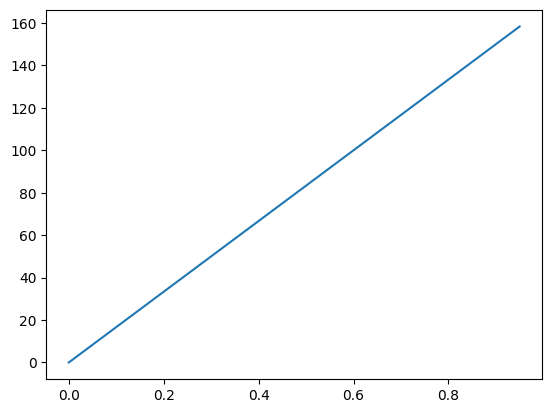

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def build_distrib_curve(bins,max_bin,max_count):
    min_bin = 0
    max_bin_index = np.searchsorted(bins,max_bin)
    count = [i * (max_count / max_bin) for i in bins]
    return count

bins = np.arange(0, 1, 0.05)
max_bin = 0.6
max_count = 100
count = build_distrib_curve(bins,max_bin,max_count)
plt.plot(bins, count)



<Axes: ylabel='Frequency'>

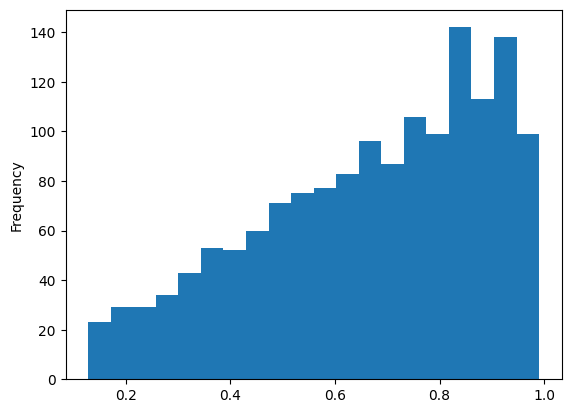

In [52]:
# Bin count of confidence
bins = np.arange(0, 1, 0.05)
# Group by bins on the confidence prediction
df1["closest_bin"] = df1["confidence_prediction"].apply(lambda x: bins[np.searchsorted(bins, x)-1])
maximum_above06 = df1[df1["closest_bin"] > 0.6].groupby("closest_bin").count().max().values[0]
corresponding_bin = df1[df1["closest_bin"] > 0.6].groupby("closest_bin").count().idxmax().values[0]

ref_count = build_distrib_curve(bins,corresponding_bin,maximum_above06)
count_mapping = {bins[i]:int(count[i]) for i in range(len(bins))}

# shuffle the data
df1 = df1.sample(frac=1).reset_index(drop=True)

# Keep only the count_mapping instances by bin
final_df1 = pd.DataFrame()
for bin_value in count_mapping:
    final_df1 = pd.concat([final_df1,df1[df1["closest_bin"] == bin_value].head(count_mapping[bin_value])])



final_df1["confidence_prediction"].plot.hist(bins=20)



In [33]:
final_df1["category"].value_counts()

NameError: name 'final_df1' is not defined

In [34]:
df1[df1.confidence_prediction > 0.3].category.value_counts()

category
Finance          1319
Politics         1064
Technology        566
Sports            559
Entertainment     533
Health            428
Environment       425
Science           359
Food              234
Education          99
Travel             69
Fashion            28
Name: count, dtype: int64

In [46]:
with open("data/provided_data/train.json", "r") as f:
    train_data = json.load(f)

records = []
for label,elements in train_data.items():
    for element in elements:
        records.append({"text":element,"label":label})

df_train = pd.DataFrame(records)

In [41]:
# Add 30 sentences from df1 to the training data
df_train_add = df1[df1.confidence_prediction > 0.3].copy()
df_train_add.rename(columns={"category":"label"},inplace=True)
df_train_add["text"] = df_train_add["text"].apply(lambda x: x.replace('"',''))
df_train = pd.concat([df_train,df_train_add[["text","label"]]])



In [42]:
df_train.label.value_counts()

label
Finance          1322
Politics         1067
Technology        569
Sports            562
Entertainment     536
Health            431
Environment       428
Science           362
Food              237
Education         102
Travel             72
Fashion            31
Name: count, dtype: int64

In [7]:
# with open("data/train_from_bbc_news.json", "r") as f:
#     data = json.load(f)

# df1 = pd.DataFrame({"category": [d["category"] for d in data],"text": [d["text"] for d in data]})

with open("data/cohere/train_from_bbcnews_dataset.json", "r") as f:
    data = json.load(f)

df2 = pd.DataFrame(data)

<Axes: ylabel='Frequency'>

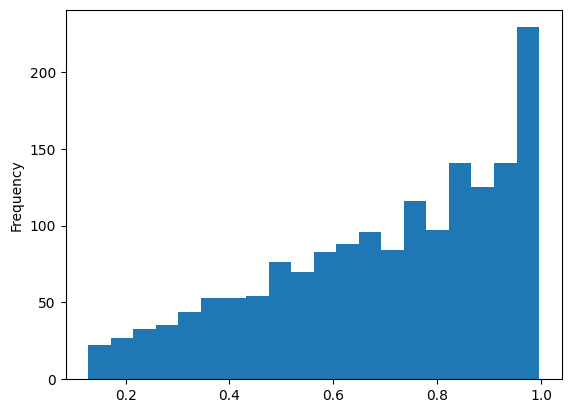

In [48]:
# Bin count of confidence
bins = np.arange(0, 1, 0.05)
# Group by bins on the confidence prediction
df2["closest_bin"] = df2["confidence_prediction"].apply(lambda x: bins[np.searchsorted(bins, x)-1])
maximum_above06 = df2[df2["closest_bin"] > 0.6].groupby("closest_bin").count().max().values[0]
corresponding_bin = df2[df2["closest_bin"] > 0.6].groupby("closest_bin").count().idxmax().values[0]

ref_count = build_distrib_curve(bins,corresponding_bin,maximum_above06)
count_mapping = {bins[i]:int(count[i]) for i in range(len(bins))}

# shuffle the data
df2 = df2.sample(frac=1).reset_index(drop=True)

# Keep only the count_mapping instances by bin
final_df2 = pd.DataFrame()
for bin_value in count_mapping:
    final_df2 = pd.concat([final_df1,df2[df2["closest_bin"] == bin_value].head(count_mapping[bin_value])])



final_df2["confidence_prediction"].plot.hist(bins=20)

In [49]:
final_df2['category'].value_counts()

category
Finance          523
Politics         269
Sports           170
Technology       161
Entertainment    141
Environment      123
Science          110
Health            84
Food              39
Education         28
Travel            10
Fashion            9
Name: count, dtype: int64

In [8]:

df2[df2.confidence_prediction > 0.3].category.value_counts()

category
Politics         6595
Finance          6305
Sports           4826
Entertainment    3020
Technology       2350
Health           1922
Food             1600
Environment      1482
Science          1145
Travel            430
Education         413
Fashion           133
Name: count, dtype: int64

In [21]:
nb_instances_to_add =dict(zip(df_train.label.value_counts().index.to_list(), (max(df_train.label.value_counts()) - df_train.label.value_counts()).to_list()))

In [43]:
# Add 30 sentences from df1 to the training data

df_train_add = df2[df2.confidence_prediction > 0.3].copy()#groupby("category",as_index=False).apply(lambda x: x.head(nb_instances_to_add[x.category.values[0]]))
df_train_add.rename(columns={"category":"label"},inplace=True)
df_train_add["text"] = df_train_add["text"].apply(lambda x: x.replace('"',''))
df_train = pd.concat([df_train,df_train_add[["text","label"]]])

In [44]:
df_train.label.value_counts()

label
Politics         7662
Finance          7627
Sports           5388
Entertainment    3556
Technology       2919
Health           2353
Environment      1910
Food             1837
Science          1507
Education         515
Travel            502
Fashion           164
Name: count, dtype: int64

In [34]:
df.drop_duplicates(subset=["text"], inplace=True)

In [35]:
len(df)

37710

<Axes: xlabel='category'>

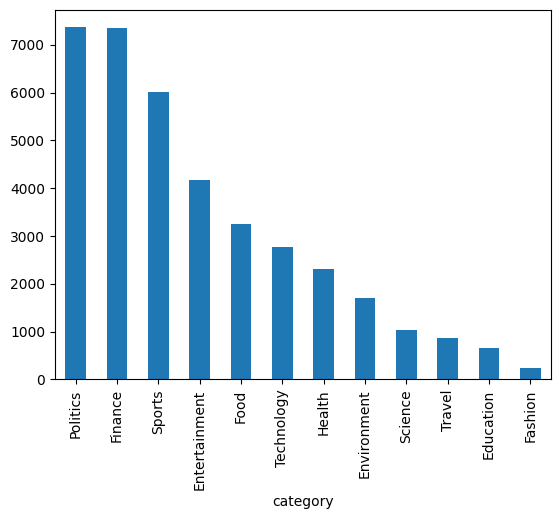

In [37]:
# Plot the distribution of the labels
df['category'].value_counts().plot(kind='bar')

In [38]:
df['category'].value_counts()

category
Politics         7360
Finance          7356
Sports           6011
Entertainment    4169
Food             3242
Technology       2773
Health           2307
Environment      1695
Science          1035
Travel            864
Education         665
Fashion           233
Name: count, dtype: int64

In [42]:
news_dataset = pd.read_csv("data/news_dataset.csv")

In [46]:
news_dataset['label'].value_counts()

label
Finance          1000
Entertainment    1000
Environment      1000
Politics         1000
Food             1000
Travel           1000
Sports           1000
Health           1000
Education         991
Science           799
Fashion           590
Technology        516
Name: count, dtype: int64

In [47]:
# Select longest sentences from categories Travel and Education 
travel_sentences = news_dataset[news_dataset['label'] == 'Travel']['text'].sort_values(key=lambda x: x.str.len(), ascending=False).tolist()
education_sentences = news_dataset[news_dataset['label'] == 'Education']['text'].sort_values(key=lambda x: x.str.len(), ascending=False).tolist()
fashion_sentences = news_dataset[news_dataset['label'] == 'Fashion']['text'].tolist()
travel_sentences = travel_sentences[:200]
education_sentences = education_sentences[:400]

new_sentences_df = pd.DataFrame({"category": ["Travel"]*len(travel_sentences) + ["Education"]*len(education_sentences) + ["Fashion"]*len(fashion_sentences), "text": travel_sentences + education_sentences + fashion_sentences})

final_df = pd.concat([df, new_sentences_df])


In [48]:
final_df['category'].value_counts()

category
Politics         7360
Finance          7356
Sports           6011
Entertainment    4169
Food             3242
Technology       2773
Health           2307
Environment      1695
Education        1065
Travel           1064
Science          1035
Fashion           823
Name: count, dtype: int64

In [51]:
# shuffle the data
final_df = final_df.sample(frac=1).reset_index(drop=True)
final_df.drop_duplicates(subset=["text"], inplace=True)

In [53]:
# Cap all the categories to 1000
final_df = final_df.groupby('category').head(1000)

final_df.to_csv("data/final_dataset.csv", index=False)

In [40]:
with open('data/News_Category_Dataset_v3.json', 'r') as f:
    lines = f.readlines()
news_category_df = pd.DataFrame([json.loads(line) for line in lines])

In [41]:
news_category_df[news_category_df['category'] == 'STYLE & BEAUTY']["short_description"].head(10)

260     Quick solutions to fix your farmer’s tan, from...
423     Jell-O is bouncy, jiggly and always snaps back...
509     Here's what to order now so you'll be itch-fre...
555     Ditch the discomfort down there with these der...
634     Experts explain the signs of melanoma to look ...
781     Four creators share exactly how much they get ...
791     The same lotions and products that you used in...
896     From puppy dog eyeliner to a trick that makes ...
931     They’re cooler and more accommodating than tho...
1286    Or perhaps nothing at all? Dermatologists shar...
Name: short_description, dtype: object